<a href="https://colab.research.google.com/github/EnsiyehRaoufi/Claims-Knowledge-Graph/blob/main/ClaimsKG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Claims Knowledge Graph Classification

### Introduction

"ClaimsKG is a structured database which serves as a registry of claims. It provides an entry point for researchers to discover claims and involved entities, also providing links to fact-checking sites and their results. Basis of the database is a knowledge graph which provides data about claims, metadata (such as their publishing site), involved entities (which we have annotated using state-of-the-art NLP techniques) and some normalized truth ratings. ClaimsKG is generated through a (semi-)automated pipeline which harvests claims and respective metadata from popular fact-checking sites on a regular basis, lifts data into an RDF/S model, which exploits established schema such as schema.org and NIF, and annotates claims with related entities from DBpedia." [[1]](#1)

I extracted the true, false and mixture claims using ClaimsKG's web interface [Claim Explorer](https://data.gesis.org/claimskg/explorer/home). There are 27588 goal claims (4404 True, 12350 False, 10834 Mixture).

Because this explorer export the results to a csv form just for a maximum of 10000 rows, so I exported each of true, false and mixture records in separate csv files. Because the distribution of all types of claims is not uniform, and both of the false and mixture claims have more than 10000 records, we lost 3184 claims to extract. But in comparison with the data set size and also, regarding to a low difference between number of total false and mixture claims, I guess it's not going to make a mistake. 

### Example
### Cleaning
### Final Advice

-------------------
<a id="1">[1]</a> 
https://data.gesis.org/claimskg/site/

# Data Set

The data is contained in three files:

* claimskg_false.csv - containing false claims and meta data about each claim (text, date, author,keywords, source, etc.)
* claimskg_mixture.csv - containing mixture claims and meta data about each claim (text, date, author,keywords, source, etc.)
* claimskg_true.csv - containing true claims and meta data about each claim (text, date, author,keywords, source, etc.)

Each of these 3 csv files contains below features:

* id (object) - claim link
* text (object) - claim text
* date (object) - claim published date
* truthRating (int64) - 
* ratingName (bool)
* author (object)
* headline (object)
* named_entities_claim (object)
* named_entities_article (object)
* keywords (object)
* source (object)
* sourceURL (object)
* link (object)
* language (object)

**Note:** You may need to 

# Installing and importing required packages

In [2]:
!pip install numpy --upgrade
!pip install autogluon --no-cache-dir

#install for keyword prediction
!pip install keybert
!pip3 install seaborn
!pip install tensorflow
!pip install tensorflow_hub
!pip install tensorflow.keras

     |████████████████████████████████| 273 kB 5.0 MB/s 
     |████████████████████████████████| 56 kB 40.1 MB/s 
     |████████████████████████████████| 52 kB 33.6 MB/s 
     |████████████████████████████████| 352 kB 59.1 MB/s 
     |████████████████████████████████| 132 kB 63.6 MB/s 
     |████████████████████████████████| 22.3 MB 1.2 MB/s 
     |████████████████████████████████| 4.2 MB 43.9 MB/s 
     |████████████████████████████████| 210 kB 79.6 MB/s 
     |████████████████████████████████| 837 kB 54.2 MB/s 
     |████████████████████████████████| 27.4 MB 1.2 MB/s 
     |████████████████████████████████| 119 kB 48.1 MB/s 
     |████████████████████████████████| 1.3 MB 45.4 MB/s 
     |████████████████████████████████| 3.0 MB 47.8 MB/s 
     |████████████████████████████████| 296 kB 64.2 MB/s 
     |████████████████████████████████| 189 kB 64.9 MB/s 
     |████████████████████████████████| 166.7 MB 1.1 MB/s 
     |████████████████████████████████| 2.0 MB 49.8 MB/s 
     |██████████

     |████████████████████████████████| 79 kB 3.8 MB/s 
     |████████████████████████████████| 217 kB 11.5 MB/s 
     |████████████████████████████████| 51 kB 6.6 MB/s 
     |████████████████████████████████| 3.5 MB 69.4 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
     |████████████████████████████████| 6.8 MB 49.6 MB/s 
  Created wheel for keybert: filename=keybert-0.5.0-py3-none-any.whl size=20491 sha256=f0f1937d80ad7e08c209094ed6d10cb2444e87451bd91dcd03b1434f3a8d3527
  Stored in directory: /root/.cache/pip/wheels/99/1f/3f/590d2997adbb2d0e1f82e8ee05d42d6910e92c3ed283015ff8
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=a102bfec8a82b83dc3054057ba77a6f1808be37c7e6080411cff18f7913246d2
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built keybert sentence-transformers
  Attempting uninstall: tokenizers
    Found existing installa

In [3]:
import datetime
import time
import tarfile
import math
import json
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keybert import KeyBERT
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag, pos_tag_sents
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
import seaborn as sns
import tensorflow_hub as hub
import tensorflow as tf
import torch
from scipy import sparse
import re 
import string


#import boto3
#from sagemaker import get_execution_role
#import sagemaker

#sm_boto3 = boto3.client("sagemaker")
#sess = sagemaker.Session()
#region = sess.boto_session.region_name
#bucket = sess.default_bucket()  # this could also be a hard-coded bucket name
#print("Using bucket " + bucket)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
#To connect to google drive in colab
from google.colab import drive
drive.mount('/content/MyDrive')
%cd MyDrive/MyDrive/claimskg
%pwd

Mounted at /content/MyDrive
/content/MyDrive/MyDrive/claimskg


'/content/MyDrive/MyDrive/claimskg'

# Reading and cleansing data

In [4]:
# read in the csv file
claims_true = pd.read_csv('claimskg_true.csv', parse_dates=['date'])
claims_false = pd.read_csv('claimskg_false.csv', parse_dates=['date'])
claims_mixture = pd.read_csv('claimskg_mixture.csv', parse_dates=['date'])

In [5]:
# Concatenating 3 tables
claimskg = pd.concat([claims_true, claims_false, claims_mixture], ignore_index=True,)

# Watch the raw input table
claimskg

,id,text,date,truthRating,ratingName,author,headline,named_entities_claim,named_entities_article,keywords,source,sourceURL,link,language
0,http://data.gesis.org/claimskg/claim_review/36...,'There will be no public funding for abortion ...,2010-03-21,3,True,Bart Stupak,Stupak revises abortion stance on health care ...,"Abortion rights,Barack Obama,Bart Stupak,Ben N...",abortion,"Abortion,Health Care",politifact,http://www.politifact.com,http://www.politifact.com/truth-o-meter/statem...,English
1,http://data.gesis.org/claimskg/claim_review/e6...,Central Health 'is the only hospital district ...,2011-03-15,3,True,Wayne Christian,State Rep. Wayne Christian says Central Health...,"Austin American-Statesman,Harris County Hospit...",NaN,Abortion,politifact,http://www.politifact.com,http://www.politifact.com/texas/statements/201...,English
2,http://data.gesis.org/claimskg/claim_review/e0...,Says most of Perry's chiefs of staff have been...,2010-08-14,3,True,Bill White,Bill White says most of Gov. Rick Perry's chie...,"AT&T,Bill Clements,Bill White,Bracewell & Giul...",NaN,Ethics,politifact,http://www.politifact.com,http://www.politifact.com/texas/statements/201...,English
3,http://data.gesis.org/claimskg/claim_review/48...,Says 'as Co-Chair of the Joint Ways & Means Co...,2012-09-28,3,True,Mary Nolan,Did Mary Nolan secure funding for Milwaukie br...,"Carolyn Tomei,Dave Hunt,Fetsch,Jeff Merkley,Ka...",Portland-Milwaukie Light Rail project,"State Budget,State Finances,Transportation",politifact,http://www.politifact.com,http://www.politifact.com/oregon/statements/20...,English
4,http://data.gesis.org/claimskg/claim_review/80...,Says Gary Farmer’s claim that he 'received an ...,2016-07-08,3,True,Jim Waldman,Florida Senate candidate never actually receiv...,"Gary Farmer,Gwyndolen Clarke-Reed,Jim Waldman,...",Gary Farmer,Guns,politifact,http://www.politifact.com,http://www.politifact.com/florida/statements/2...,English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24447,http://data.gesis.org/claimskg/claim_review/41...,'The city that I was mayor of was 50 percent L...,2018-06-07,2,MIXTURE,Lou Barletta,Hazleton wasn’t half-Latino when Lou Barletta ...,"Barletta,Bob Casey,Fox Business Network,Hazlet...",Latino,Immigration,politifact,http://www.politifact.com,http://www.politifact.com/pennsylvania/stateme...,English
24448,http://data.gesis.org/claimskg/claim_review/9e...,A set of images show a congenital anomaly that...,Unknown,2,MIXTURE,Unknown,Is This a Real Hand With Eight Fingers?,"American Society for Surgery of the Hand,Bilas...",NaN,"hands, Medical, medical anomalies, mirror hand",snopes,http://www.snopes.com,https://www.snopes.com/fact-check/real-hand-ei...,English
24449,http://data.gesis.org/claimskg/claim_review/1a...,'You see 34 people (are) murdered every single...,2012-12-23,2,MIXTURE,Cory Booker,Cory Booker says 34 Americans are killed by gu...,"ABC,Centers for Disease Control and Prevention...",NaN,"Crime,Guns",politifact,http://www.politifact.com,http://www.politifact.com/new-jersey/statement...,English
24450,http://data.gesis.org/claimskg/claim_review/28...,'White men have committed more mass shootings ...,2017-10-02,2,MIXTURE,Newsweek,Are white males responsible for more mass shoo...,"2015 San Bernardino shooting,Aurora, Colo,Foll...",NaN,Guns,politifact,http://www.politifact.com,http://www.politifact.com/punditfact/statement...,English


## Some early exploratory of NaN data

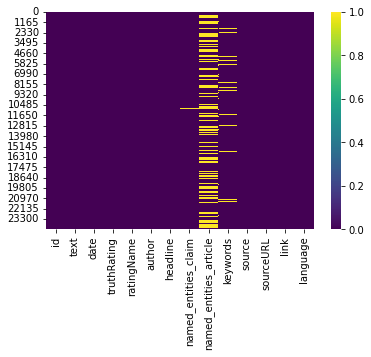

In [6]:
#let’s see what is the proportion of NaN values using seaborn
sns.heatmap(claimskg.isnull(), cmap='viridis')

In [7]:
#View true claims infographic
claimskg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24452 entries, 0 to 24451
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      24452 non-null  object
 1   text                    24452 non-null  object
 2   date                    24452 non-null  object
 3   truthRating             24452 non-null  int64 
 4   ratingName              24452 non-null  object
 5   author                  24452 non-null  object
 6   headline                24452 non-null  object
 7   named_entities_claim    24421 non-null  object
 8   named_entities_article  15340 non-null  object
 9   keywords                23162 non-null  object
 10  source                  24452 non-null  object
 11  sourceURL               24452 non-null  object
 12  link                    24452 non-null  object
 13  language                24452 non-null  object
dtypes: int64(1), object(13)
memory usage: 2.6+ MB


In [8]:
#Getting unique source's names
source_list = claimskg.source.unique()
print("Names of all sources: ", source_list)
print('**************************************************')

#pop unimportant columns:

#We pop the sourceURL because we have done one-hot encoding on the source column
claimskg.pop('sourceURL')

#Because languages of all claims are English, so we can neglect the column 'language'
print("Languges of all claims: ", claimskg.language.unique())
claimskg.pop('language')
print('**************************************************')

print("Number of unique dates: ", len(claimskg.date.unique()))

#it does not seem that date would be important in results by looking at feature importance of autogluon predictor after several runs. so we drop it
claimskg.pop('date')
print('**************************************************')

print("Number of unique Rating names: ", len(claimskg.ratingName.unique()))
print('**************************************************')

print("False Rating class number: ", claimskg[claimskg['ratingName']==False]['truthRating'].iloc[0])
print("MIXTURE Rating class number: ", claimskg[claimskg['ratingName']=='MIXTURE']['truthRating'].iloc[0])
print("True Rating class number: ", claimskg[claimskg['ratingName']==True]['truthRating'].iloc[2])
print('**************************************************')

claimskg.info()

Names of all sources:  ['politifact' 'snopes' 'africacheck' 'truthorfiction' 'factscan'
 'checkyourfact']
**************************************************
Languges of all claims:  ['English']
**************************************************
Number of unique dates:  3738
**************************************************
Number of unique Rating names:  3
**************************************************
False Rating class number:  1
MIXTURE Rating class number:  2
True Rating class number:  3
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24452 entries, 0 to 24451
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      24452 non-null  object
 1   text                    24452 non-null  object
 2   truthRating             24452 non-null  int64 
 3   ratingName              24452 non-null  object
 4   author               

In [9]:
#print some information about the data set
print("Number of unique authors: ", len(claimskg.author.unique()))
print("Number of unique article named entities: ", len(claimskg.named_entities_article.unique()))
print("Number of unique article named entities: ", len(claimskg.keywords.unique()))

#Obtain indexes of claimskg where the keywords are NaN
nan_keywords =np.where(pd.isnull(claimskg['keywords']))
print("Number of NaN keyword claims: ", len(nan_keywords[0]))
print("Index on NaN keywords: ", nan_keywords)

Number of unique authors:  3885
Number of unique article named entities:  10022
Number of unique article named entities:  10156
Number of NaN keyword claims:  1290
Index on NaN keywords:  (array([    7,    12,    30, ..., 24335, 24388, 24392]),)


# Deal with NaNs

In [10]:

tf.test.gpu_device_name()
torch.cuda.is_available()

def get_default_device():
    """Picking GPU if available or else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
print(device)

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)



cuda


In [11]:
def keywords(doc, kw_model, max_length, top_n):
  ''' Getting keywords of a document by using keyBert
    returns the obtained keywords
  '''
  n_gram_range = tuple((1, max_length))
  #we might not want to remove stop_words sometimes as they can tie longer keyphrases together.
  top_n = top_n

  keyword = kw_model.extract_keywords(doc, keyphrase_ngram_range=n_gram_range, top_n=top_n, ) 
  #we can add extra options like Max Sum Similarity by set use_maxsum=True, nr_candidates=10,
  #Or add Maximal Marginal Relevance by set use_mmr=True, diversity=0.5
  #We neglet these because of being time-consuming

  #creating a similar string to other cells in 'keywords' column
  keyword_string=''
  for key in keyword:
    keyword_string+=','+key[0]
  keyword_string = keyword_string[1:]
  return keyword_string

In [12]:
#filling the cells having nan in the 'keywords' column using keyBERT

kw_model = KeyBERT()
#to_device(kw_model,device)

for i in nan_keywords[0]:
  claimskg.iloc[i, claimskg.columns.get_loc('keywords')] = keywords(claimskg.iloc[i]['text']+','+claimskg.iloc[i]['headline'], kw_model, max_length=2, top_n=5)
# run time: 1 minute one Colab gpu

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
#Saving the table with full
claimskg.to_csv("claimskg_all_keywords.csv", index=False)

In [14]:
claimskg = pd.read_csv("claimskg_all_keywords.csv")

In [15]:
claimskg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24452 entries, 0 to 24451
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      24452 non-null  object
 1   text                    24452 non-null  object
 2   truthRating             24452 non-null  int64 
 3   ratingName              24452 non-null  object
 4   author                  24452 non-null  object
 5   headline                24452 non-null  object
 6   named_entities_claim    24421 non-null  object
 7   named_entities_article  15340 non-null  object
 8   keywords                24452 non-null  object
 9   source                  24452 non-null  object
 10  link                    24452 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.1+ MB


In [16]:
#Obtain indexes of claimskg where the named_entities_claim are NaN
nan_claim_entity =np.where(pd.isnull(claimskg['named_entities_claim']))
print("Number of NaN keyword claims: ", len(nan_claim_entity[0]))
print("Index on NaN keywords: ", nan_claim_entity)

Number of NaN keyword claims:  31
Index on NaN keywords:  (array([  172,  1328,  1609,  1870,  1910,  2234,  4585,  5104,  5708,
        6225,  7107,  7845,  9446,  9991, 10895, 10923, 10932, 11263,
       11460, 11734, 12473, 12569, 13246, 13440, 13541, 13921, 13967,
       16570, 16872, 17946, 20348]),)


In [17]:
##filling the cells having nan in the 'named_entities_claim' column using keyBERT

for i in nan_claim_entity[0]:
  choices_list = claimskg.iloc[i, claimskg.columns.get_loc('headline')] +','+ claimskg.iloc[i, claimskg.columns.get_loc('text')]
  claimskg.iloc[i, claimskg.columns.get_loc('named_entities_claim')] = keywords(choices_list, kw_model, max_length=6, top_n=10)


In [18]:
#Saving table with full lemmatized named_entities_claim column
claimskg.to_csv("claimskg_all_entities_claim.csv", index=False)

In [19]:
claimskg = pd.read_csv("claimskg_all_entities_claim.csv")

In [20]:
claimskg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24452 entries, 0 to 24451
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      24452 non-null  object
 1   text                    24452 non-null  object
 2   truthRating             24452 non-null  int64 
 3   ratingName              24452 non-null  object
 4   author                  24452 non-null  object
 5   headline                24452 non-null  object
 6   named_entities_claim    24452 non-null  object
 7   named_entities_article  15340 non-null  object
 8   keywords                24452 non-null  object
 9   source                  24452 non-null  object
 10  link                    24452 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.1+ MB


In [21]:
#Obtain indexes of claimskg where the named_entities_article are NaN
nan_article_list =np.where(pd.isnull(claimskg['named_entities_article']))
print("Number of NaN keyword claims: ", len(nan_article_list[0]))
print("Index on NaN keywords: ", nan_article_list)

Number of NaN keyword claims:  9112
Index on NaN keywords:  (array([    1,     2,     5, ..., 24449, 24450, 24451]),)


### Using headline and named_entities_claim to recognize the top 2 article topics
Looking at the non NaN named_entities_article cells this seems sensible filling the NaN cells using headline and named_entities_claim. 

**Note: It's the bottleneck of my program and not using the Colab GPU, it's takes about 40 minutes for running. This is because there are too many words on the named_entities_claim column- one of the columns we are using for prediction- and because we are searching for both single words and 2-grams, the number of choices will become too much.**

Offer: We can use only single words to article named-entity recognition. I mean change the max_length to 1.

In [22]:
for i in nan_article_list[0]:
  choices_list = claimskg.iloc[i, claimskg.columns.get_loc('headline')] +','+ claimskg.iloc[i, claimskg.columns.get_loc('named_entities_claim')]
  claimskg.iloc[i, claimskg.columns.get_loc('named_entities_article')] = keywords(choices_list, kw_model, max_length=2, top_n=2)

#less than 8 minutes run on my Colab gpu, otherwise it's so time-consuming

In [24]:
claimskg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24452 entries, 0 to 24451
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      24452 non-null  object
 1   text                    24452 non-null  object
 2   truthRating             24452 non-null  int64 
 3   ratingName              24452 non-null  object
 4   author                  24452 non-null  object
 5   headline                24452 non-null  object
 6   named_entities_claim    24452 non-null  object
 7   named_entities_article  24452 non-null  object
 8   keywords                24452 non-null  object
 9   source                  24452 non-null  object
 10  link                    24452 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.1+ MB


In [25]:
claimskg.to_csv("claimskg_all_articles.csv", index=False)

# Lowercase, Lemmatize, Stem and, Remove Stop Words and Puncuations 

In [29]:
claimskg = pd.read_csv("claimskg_all_articles.csv")

In [30]:
claimskg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24452 entries, 0 to 24451
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      24452 non-null  object
 1   text                    24452 non-null  object
 2   truthRating             24452 non-null  int64 
 3   ratingName              24452 non-null  object
 4   author                  24452 non-null  object
 5   headline                24452 non-null  object
 6   named_entities_claim    24452 non-null  object
 7   named_entities_article  24452 non-null  object
 8   keywords                24452 non-null  object
 9   source                  24452 non-null  object
 10  link                    24452 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.1+ MB


In [31]:
#pos tagging and adding POS column to dataset

#texts = claimskg['text']
#claimskg['POS'] = pos_tag_sents(map(word_tokenize, texts))


In [32]:
#remove punctuation from columns

columns = ['text', 'headline','author', 'named_entities_claim','named_entities_article', 'keywords']
for col in columns:
  #make text lowercase
  claimskg[col] = claimskg[col].apply(lambda x: x.lower())
  #Because we replaced the special characters with a plus, we might end up with double whitespaces in some cases
  claimskg[col] = claimskg[col].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ' , x))
  #remove digits
  claimskg[col] = claimskg[col].apply(lambda x: re.sub('W*\dw*',' ',x))
  #remove extra spaces
  claimskg[col] = claimskg[col].apply(lambda x: re.sub('[\t\r\n\f]',' ',x))

In [33]:
#Remove stop words of the all necessary columns
stop_words = set(stopwords.words('english'))

def remove_stop_word(text):
    return " ".join(w for w in word_tokenize(text) if not w.lower() in stop_words)

#Do on all textual columns except for author 
columns.remove('author')
for col in columns:
  df = claimskg[col].copy()
  df = pd.DataFrame(df)
  df['text_stopped'] = df[col].apply(remove_stop_word)
  claimskg[col] = df.text_stopped


In [34]:
#Lemmatization all the necessary columns
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text))

for col in columns:
  df = claimskg[col].copy()
  df = pd.DataFrame(df)
  df['text_lemmatized'] = df[col].apply(lemmatize_text)
  claimskg[col] = df.text_lemmatized


In [35]:
#stemming
stemmer = PorterStemmer()

def stem_words(text):
  return " ".join([stemmer.stem(word) for word in nltk.word_tokenize(text)])

for col in columns:
  df = claimskg[col].copy()
  df = pd.DataFrame(df)
  df['text_stemmed'] = df[col].apply(stem_words)
  claimskg[col] = df.text_stemmed


In [36]:
#Let's take a look at our edited data set
claimskg

,id,text,truthRating,ratingName,author,headline,named_entities_claim,named_entities_article,keywords,source,link
0,http://data.gesis.org/claimskg/claim_review/36...,public fund abort legisl,3,True,bart stupak,stupak revis abort stanc health care bill cite...,abort right barack obama bart stupak ben nelso...,abort,abort health care,politifact,http://www.politifact.com/truth-o-meter/statem...
1,http://data.gesis.org/claimskg/claim_review/e6...,central health hospit district texa spend taxp...,3,True,wayne christian,state rep wayn christian say central health tr...,austin american statesman harri counti hospit ...,travi counti counti texa,abort,politifact,http://www.politifact.com/texas/statements/201...
2,http://data.gesis.org/claimskg/claim_review/e0...,say perri chief staff lobbyist,3,True,bill white,bill white say gov rick perri chief staff lobb...,bill clement bill white bracewel giuliani brac...,staff lobbyist lobbyist clement,ethic,politifact,http://www.politifact.com/texas/statements/201...
3,http://data.gesis.org/claimskg/claim_review/48...,say co chair joint way mean committe secur key...,3,True,mary nolan,mari nolan secur fund milwauki bridg project,carolyn tomei dave hunt fetsch jeff merkley ka...,portland milwauki light rail project,state budget state financ transport,politifact,http://www.politifact.com/oregon/statements/20...
4,http://data.gesis.org/claimskg/claim_review/80...,say gari farmer ’ claim receiv nra absolut lie,3,True,jim waldman,florida senat candid never actual receiv nra,gari farmer gwyndolen clark reed jim waldman l...,gari farmer,gun,politifact,http://www.politifact.com/florida/statements/2...
...,...,...,...,...,...,...,...,...,...,...,...
24447,http://data.gesis.org/claimskg/claim_review/41...,citi mayor percent latino percent vote,2,MIXTURE,lou barletta,hazleton ’ half latino lou barletta elect mayo...,barletta bob casey fox busi network hazleton i...,latino,immigr,politifact,http://www.politifact.com/pennsylvania/stateme...
24448,http://data.gesis.org/claimskg/claim_review/9e...,set imag show congenit anomali result hand eig...,2,MIXTURE,unknown,real hand eight finger,american societi surgeri hand bilaspur faceboo...,surgeri hand real hand,hand medic medic anomali mirror hand,snopes,https://www.snopes.com/fact-check/real-hand-ei...
24449,http://data.gesis.org/claimskg/claim_review/1a...,see peopl murder everi singl day gunfir america,2,MIXTURE,cory booker,cori booker say american kill gun everi day,abc center diseas control prevent cori booker ...,stephanopoulo gun mass shoot,crime gun,politifact,http://www.politifact.com/new-jersey/statement...
24450,http://data.gesis.org/claimskg/claim_review/28...,white men commit mass shoot group,2,MIXTURE,newsweek,white male respons mass shoot group,san bernardino shoot aurora colo follman grant...,mass shoot mass shoot,gun,politifact,http://www.politifact.com/punditfact/statement...


In [37]:
#Save the edited table as a csv file
claimskg.to_csv("claimskg_lemm_stop_stem_punc.csv", index=False)

## Check for NaNs

In [38]:
claimskg = pd.read_csv("claimskg_lemm_stop_stem_punc.csv")

In [39]:
#After lemmatization, stemming and removing stop words, we got some NaN objects again
claimskg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24452 entries, 0 to 24451
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      24452 non-null  object
 1   text                    24451 non-null  object
 2   truthRating             24452 non-null  int64 
 3   ratingName              24452 non-null  object
 4   author                  24452 non-null  object
 5   headline                24450 non-null  object
 6   named_entities_claim    24450 non-null  object
 7   named_entities_article  24426 non-null  object
 8   keywords                24447 non-null  object
 9   source                  24452 non-null  object
 10  link                    24452 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.1+ MB


In [40]:
#Removing rows containing NaNs because of their minority
claimskg = claimskg.dropna()
claimskg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24416 entries, 0 to 24451
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      24416 non-null  object
 1   text                    24416 non-null  object
 2   truthRating             24416 non-null  int64 
 3   ratingName              24416 non-null  object
 4   author                  24416 non-null  object
 5   headline                24416 non-null  object
 6   named_entities_claim    24416 non-null  object
 7   named_entities_article  24416 non-null  object
 8   keywords                24416 non-null  object
 9   source                  24416 non-null  object
 10  link                    24416 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.2+ MB


In [42]:
claimskg.to_csv("claimskg_fulledited_1.csv", index=False)

# Some Exploratory Data

In [45]:
#Obtain number of unique authors, keywords and articles in the whole data set

unique_keys = set()
for key_list in claimskg['keywords']:
  for key in key_list.split():
    unique_keys.add(key)
print("Number of unique keywords: ",len(unique_keys))

unique_keys = set()
for key_list in claimskg['named_entities_article']:
    for key in key_list.split():
      unique_keys.add(key)
print("Number of unique articles: ",len(unique_keys))

unique_keys = set()
for key in claimskg['author']:
  unique_keys.add(key)
print("Number of unique authors: ",len(unique_keys))
unique_authors = unique_keys

unique_keys = set()
for key in claimskg['text']:
  unique_keys.add(key)
print("Number of unique words in texts: ",len(unique_keys))

unique_keys = set()
for key in claimskg['named_entities_claim']:
  unique_keys.add(key)
print("Number of unique words in named_entities_claim: ",len(unique_keys))

unique_keys = set()
for key in claimskg['headline']:
  unique_keys.add(key)
print("Number of unique words in headline: ",len(unique_keys))


Number of unique keywords:  6984
Number of unique articles:  10062
Number of unique authors:  3876
Number of unique words in texts:  24332
Number of unique words in named_entities_claim:  24261
Number of unique words in headline:  24263


## Imbalanced Classes Preview

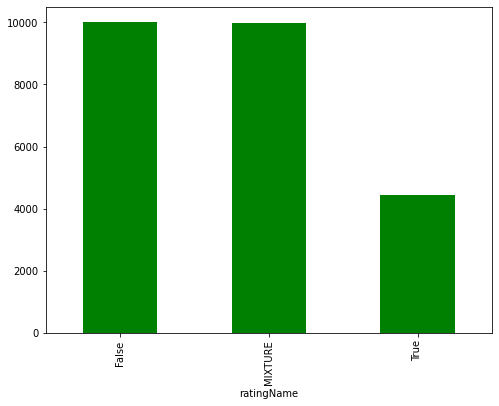

In [47]:
#Imbalanced Classes

fig = plt.figure(figsize=(8,6))
claimskg.groupby('ratingName').ratingName.count().plot.bar(ylim=0, color="g")
plt.show()

# Transformer hub
- Her we got some early results before vectorizing the text using Transformer-hub Auto-ML model. TensorFlow Hub is a repository of trained machine learning models ready for fine-tuning and deployable anywhere. 

In [48]:
claimskg = pd.read_csv('claimskg_fulledited_1.csv')

In [50]:
#for chan in claimskg['truthRating']:
 #   claimskg['goal'+str(chan)] = claimskg.truthRating.apply(lambda x: 1 if x==chan else 0)
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y = to_categorical(le.fit_transform(claimskg['ratingName']))
y

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [51]:
train_data = claimskg['text']+' '+claimskg['author']+' '+ claimskg['headline']+' '+ \
              claimskg['named_entities_claim']+' '+claimskg['named_entities_article']+' '+ claimskg['keywords']+' ' + claimskg['source']

In [52]:
claimskg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24416 entries, 0 to 24415
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      24416 non-null  object
 1   text                    24416 non-null  object
 2   truthRating             24416 non-null  int64 
 3   ratingName              24416 non-null  object
 4   author                  24416 non-null  object
 5   headline                24416 non-null  object
 6   named_entities_claim    24416 non-null  object
 7   named_entities_article  24416 non-null  object
 8   keywords                24416 non-null  object
 9   source                  24416 non-null  object
 10  link                    24416 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.0+ MB


In [53]:
from sklearn.model_selection import train_test_split

# split data set into TRAIN, DEV, and TEST sets
X_train, X_dev, y_train, y_dev = train_test_split(train_data, 
                                                  y, test_size=0.2, random_state=42)  # 20% for DEV and TEST

# split DEV further into DEV and TEST
X_dev, X_test, y_dev, y_test = train_test_split(X_dev, y_dev, test_size=0.5, random_state=42)

In [54]:
import tensorflow_hub as hub

# load embeddings model from Tensorflow Hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# convert sentences to embeddings
X_train = embed(X_train)
X_dev = embed(X_dev)
X_test = embed(X_test)

In [55]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

# build Sequential model with 3 layers
model = Sequential()
model.add(Dense(units=32, activation="relu"))  # input layer
model.add(Dense(units=64, activation="relu"))  # hidden layer
model.add(Dense(units=3, activation="softmax"))  # output layer, no. of units equals no. of classes
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
model.fit(x=X_train, y=y_train,
          epochs=100,
          validation_data=(X_dev, y_dev),
          batch_size=16,
          verbose=1)

Epoch 1/100
1221/1221 [==============================] - 6s 4ms/step - loss: 0.9122 - accuracy: 0.5967 - val_loss: 0.8884 - val_accuracy: 0.6020
Epoch 2/100
1221/1221 [==============================] - 5s 4ms/step - loss: 0.8791 - accuracy: 0.6102 - val_loss: 0.8791 - val_accuracy: 0.6020
Epoch 3/100
1221/1221 [==============================] - 7s 6ms/step - loss: 0.8613 - accuracy: 0.6167 - val_loss: 0.8727 - val_accuracy: 0.6073
Epoch 4/100
1221/1221 [==============================] - 9s 7ms/step - loss: 0.8456 - accuracy: 0.6260 - val_loss: 0.8731 - val_accuracy: 0.6065
Epoch 5/100
1221/1221 [==============================] - 6s 5ms/step - loss: 0.8303 - accuracy: 0.6315 - val_loss: 0.8790 - val_accuracy: 0.6048
Epoch 6/100
1221/1221 [==============================] - 5s 4ms/step - loss: 0.8119 - accuracy: 0.6441 - val_loss: 0.9051 - val_accuracy: 0.5991
Epoch 7/100
1221/1221 [==============================] - 5s 4ms/step - loss: 0.7947 - accuracy: 0.6491 - val_loss: 0.8944 - val_ac

In [57]:
import numpy as np
from sklearn.metrics import classification_report

predictions = np.argmax(model.predict(X_test), axis=-1)
y_test = le.inverse_transform([np.argmax(y) for y in y_test])  # reconstruct original string labels
predictions = le.inverse_transform(predictions)
report = classification_report(y_test, predictions)
report

'              precision    recall  f1-score   support\n\n       False       0.57      0.53      0.55       999\n     MIXTURE       0.54      0.54      0.54       971\n        True       0.25      0.28      0.27       472\n\n    accuracy                           0.49      2442\n   macro avg       0.45      0.45      0.45      2442\nweighted avg       0.49      0.49      0.49      2442\n'

In [58]:
#Create a column contains bag of words of the text
#import collections
#claimskg['BOW'] = claimskg.text.apply(lambda x: collections.Counter([y for y in x.split()]))
#claimskg.to_csv("claimskg_edited_2.csv", index=False)

# Vectorization
Changing every text column to a numerical form: All machine learning models use mathematics and numbers to compute data. 
Since the input here is textual, we will use the TF-IDF (Term Frequency and Document Frequency) scheme and, because our classes are unbalanced and have different counts of words, we don't use BoW (Bag of Word) and just care about importance ratio of the words in each class.

In [173]:
claimskg = pd.read_csv('claimskg_fulledited_1.csv')

In [174]:
#Create a list of three class dataframes i.e. df_class[0]: False class.
df_class=[]
for i in range(3):
  df_class.append(claimskg[claimskg['truthRating']== i+1])
  print(f"Number of claims of Class {i+1}: ", len(df_class[i]))
print("Class 1: False, Class 2: Mixture, Class 3: True claims")


Number of claims of Class 1:  9993
Number of claims of Class 2:  9983
Number of claims of Class 3:  4440
Class 1: False, Class 2: Mixture, Class 3: True claims


In [175]:
#Vectorizing columns using TF-IDF metric based on each class(False, Mixture, True)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

source_df = []
for i in range(3):
  vectorizer = TfidfVectorizer(max_features=150, min_df=0.005, max_df=0.9 ,ngram_range=(1,2))
  vectorized_col = vectorizer.fit_transform(df_class[i]['text']).toarray()
  vec_features = vectorizer.get_feature_names()
  print("number of text features:" ,len(vec_features))
  source_df.append(pd.DataFrame()) 
  source_df[i][vec_features] = vectorized_col
  print('*************')

  vectorized_col = vectorizer.fit_transform(df_class[i]['named_entities_claim']).toarray()
  vec_features = vectorizer.get_feature_names()
  print("number of named_entities_claim features:" ,len(vec_features))

  j = 0
  for feat in vec_features:
    #if the new generated feature is existed then we add its amount with previous amounts
    if feat in source_df[i].columns:
      source_df[i][feat] = source_df[i][feat] + vectorized_col[:,j]
    else:
      source_df[i][feat] = vectorized_col[:,j]
    j+=1

  print('*************')

  vectorized_col = vectorizer.fit_transform(df_class[i]['keywords']).toarray()
  vec_features = vectorizer.get_feature_names()
  print("number of keyword features:" ,len(vec_features))

  j = 0
  for feat in vec_features:
    if feat in source_df[i].columns:
      source_df[i][feat] = source_df[i][feat] + vectorized_col[:,j]
    else:
      source_df[i][feat] = vectorized_col[:,j]
    j+=1

  print('*************')

  vectorized_col = vectorizer.fit_transform(df_class[i]['named_entities_article']).toarray()
  vec_features = vectorizer.get_feature_names()
  print("number of named_entities_article features:" ,len(vec_features))

  j = 0
  for feat in vec_features:
    if feat in source_df[i].columns:
      source_df[i][feat] = source_df[i][feat] + vectorized_col[:,j]
    else:
      source_df[i][feat] = vectorized_col[:,j]
    j+=1

  print('*************')

  vectorized_col = vectorizer.fit_transform(df_class[i]['headline']).toarray()
  vec_features = vectorizer.get_feature_names()
  print("number of headline features:" ,len(vec_features))

  j = 0
  for feat in vec_features:
    if feat in source_df[i].columns:
      source_df[i][feat] = source_df[i][feat] + vectorized_col[:,j]
    else:
      source_df[i][feat] = vectorized_col[:,j]
    j+=1

  print('*************')

  vectorizer = TfidfVectorizer(min_df=0.005, max_df=0.8 ,ngram_range=(1,1))
  vectorized_col = vectorizer.fit_transform(df_class[i]['source']).toarray()
  vec_features = vectorizer.get_feature_names()
  print("number of source features:" ,len(vec_features))

  j = 0
  for feat in vec_features:
    if feat in source_df[i].columns:
      source_df[i][feat] = source_df[i][feat] + vectorized_col[:,j]
    else:
      source_df[i][feat] = vectorized_col[:,j]
    j+=1
  print('*************')

  vectorizer = TfidfVectorizer(max_features=150, min_df=0.005, max_df=0.9 ,ngram_range=(2,2))
  vectorized_col = vectorizer.fit_transform(df_class[i]['author']).toarray()
  vec_features = vectorizer.get_feature_names()
  print("number of author features:" ,len(vec_features))

  j = 0
  for feat in vec_features:
    if feat in source_df[i].columns:
      source_df[i][feat] = source_df[i][feat] + vectorized_col[:,j]
    else:
      source_df[i][feat] = vectorized_col[:,j]
    j+=1

  print('++++++++++++++++++++++++++++++')


number of text features: 150
*************


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


number of named_entities_claim features: 150
*************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


number of keyword features: 150
*************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


number of named_entities_article features: 74
*************


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


number of headline features: 150
*************
number of source features: 4
*************
number of author features: 5
++++++++++++++++++++++++++++++


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, u

number of text features: 150
*************
number of named_entities_claim features: 150
*************
number of keyword features: 150
*************
number of named_entities_article features: 106
*************
number of headline features: 150
*************
number of source features: 2
*************
number of author features: 20
++++++++++++++++++++++++++++++
number of text features: 150
*************
number of named_entities_claim features: 150
*************
number of keyword features: 135
*************
number of named_entities_article features: 83
*************
number of headline features: 150
*************
number of source features: 5
*************
number of author features: 7
++++++++++++++++++++++++++++++


In [176]:
#Adding class name and labels to the 3 classes data sets
for i in range(3):
  source_df[i] = source_df[i].assign(target_labels=i+1)
source_df[0] = source_df[0].assign(target_names='False')
source_df[1] = source_df[1].assign(target_names='Mixture')
source_df[2] = source_df[2].assign(target_names='True')

#Merging 3 classes
source_df = pd.concat(source_df, ignore_index=True, sort=True).copy()
print(source_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24416 entries, 0 to 24415
Columns: 555 entries, abc to youtub
dtypes: float64(553), int64(1), object(1)
memory usage: 103.4+ MB
None


In [177]:
#Filling the NaN
source_df = source_df.fillna(0).copy()

#sum every two duplicate columns
source_df = source_df.groupby(source_df.columns, axis=1).sum().copy()

#Remove duplicate columns
source_df = source_df.T.drop_duplicates().T.copy()

source_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24416 entries, 0 to 24415
Columns: 544 entries, abc to youtub
dtypes: object(544)
memory usage: 102.0+ MB


In [179]:
#Shuffling my feature extracted data
import sklearn.utils
source_df = sklearn.utils.shuffle(source_df)

#Reset indexes
source_df = source_df.reset_index(drop=True).copy()

#Change the order of columns
column_list = list(source_df.columns)
column_list.remove('target_labels')
column_list.remove('target_names')
column_list.append('target_labels')
column_list.append('target_names')
source_df = source_df[column_list]

#Save to csv file
source_df.to_csv("source_features.csv", index=False)

#Release the RAM
del claimskg


In [180]:
#View the head and the shape of data
print(source_df.head())
print("Shape of the data: ", source_df.shape)

   abc abc news     abort accid  ... york time youtub target_labels target_names
0  0.0      0.0  0.781603   0.0  ...       0.0    0.0             2      Mixture
1  0.0      0.0       0.0   0.0  ...       0.0    0.0             2      Mixture
2  0.0      0.0       0.0   0.0  ...       0.0    0.0             2      Mixture
3  0.0      0.0       0.0   0.0  ...       0.0    0.0             1        False
4  0.0      0.0       0.0   0.0  ...  0.527853    0.0             3         True

[5 rows x 544 columns]
Shape of the data:  (24416, 544)


# Multi Class Classification
We want to classify every sample of our data to be in the class 1: Flase, 2: Mixture, 3: True. These labels have been given to the claims by human annotating or ML feature engineering.

## Chi-Square 
"Chi-Square is to be used when the feature is categorical, the target variable is any way can be thought as categorical. It measures the degree of association between two categorical variables". [1](https://towardsdatascience.com/using-the-chi-squared-test-for-feature-selection-with-implementation-b15a4dad93f1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [182]:
#Ecncode labels
source_df = pd.read_csv("source_features.csv")
source_df.target_names = source_df.target_names.astype('string')
category_id_df = source_df[['target_names', 'target_labels']].drop_duplicates().sort_values('target_labels')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['target_labels', 'target_names']].values)
labels = source_df.target_labels
category_to_id

{'False': 1, 'Mixture': 2, 'True': 3}

In [183]:
#View most important features

N = 5
for claim, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2( source_df.iloc[:,:-2], labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(source_df.columns)[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(claim))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
  print("*************************************")
 # i+=1

# 'False':
  . Most correlated unigrams:
. muslim
. news
. politifact
. fake
. snopes
  . Most correlated bigrams:
. chain email
. facebook posts
. viral image
. mitt romney
. fake news
*************************************
# 'Mixture':
  . Most correlated unigrams:
. asp
. articl
. fake
. snopes
. politifact
  . Most correlated bigrams:
. marco rubio
. scott walker
. rick scott
. mitt romney
. fake news
*************************************
# 'True':
  . Most correlated unigrams:
. letter
. mccain
. truth
. island
. politifact
  . Most correlated bigrams:
. photograph show
. anim asp
. censu bureau
. fake news
. lo angel
*************************************


In [184]:
#Create train and test dataset
X_train = source_df.iloc[:,:-2][:17000]
y_train = source_df.target_labels[:17000]
X_test = source_df.iloc[:,:-2][17000:]
y_test = source_df.target_labels[17000:]

## Random Forest Classifier
"Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time."[1](https://en.wikipedia.org/wiki/Random_forest)

In [190]:
#Random Forest Classifier fitting
min_samples_leaf = 3
n_estimators = 300
rf_classifier = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, n_jobs=-1)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=3, n_estimators=300, n_jobs=-1)

In [191]:
#Prediction of test data
y_pred = rf_classifier.predict(X_test)
y_pred

array([2, 1, 1, ..., 2, 3, 2])

In [192]:
#Evaluating the model

print(f"Random Forest Evaluation result with {n_estimators} estimators and  \
{min_samples_leaf} leaves.\n 1: False, 2: Mixture, 3:True")
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

Random Forest Evaluation result with 300 estimators and  3 leaves.
 1: False, 2: Mixture, 3:True
Confusion matrix: 
 [[2936  124    7]
 [  70 2941    1]
 [ 331  135  871]]
Classification report:
               precision    recall  f1-score   support

           1       0.88      0.96      0.92      3067
           2       0.92      0.98      0.95      3012
           3       0.99      0.65      0.79      1337

    accuracy                           0.91      7416
   macro avg       0.93      0.86      0.88      7416
weighted avg       0.92      0.91      0.91      7416



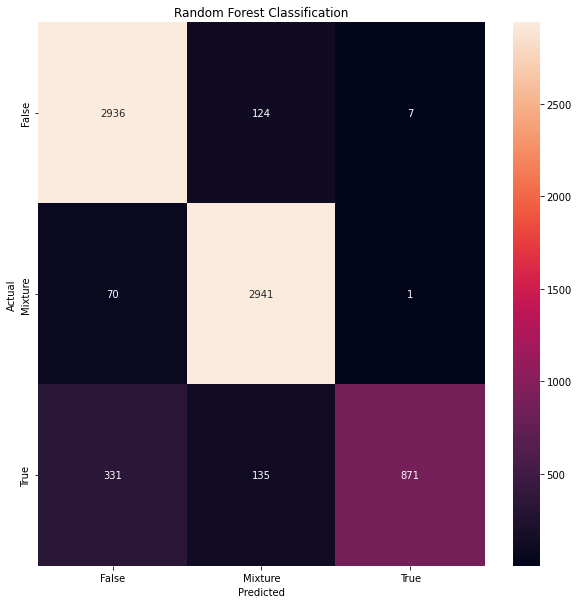

In [195]:
#Prediction visualization

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.target_names.values, yticklabels=category_id_df.target_names.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Random Forest Classification")
plt.show()

## Multinomial Naive Bayes Classifier
This algorithm is a Bayesian learning approach popular in Natural Language Processing (NLP). The algorithm guesses the label of a claim, such as True, False or Mixture, using the Bayes theorem. It calculates each label's likelihood for a given sample and outputs the label with the greatest chance.

In [216]:
#Multinomial Naive Bayes Classifier

clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [217]:
#Make predictions

y_pred = clf.predict(X_test)
y_pred

array([1, 1, 1, ..., 2, 3, 2])

In [218]:
#Evaluating the model

print("Multinomial Naive Bayes Classifier result for \n Class 1: False, Class 2: Mixture, Class 3:True")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Multinomial Naive Bayes Classifier result for 
 Class 1: False, Class 2: Mixture, Class 3:True
[[2571  276  220]
 [ 351 2580   81]
 [ 365  147  825]]
              precision    recall  f1-score   support

           1       0.78      0.84      0.81      3067
           2       0.86      0.86      0.86      3012
           3       0.73      0.62      0.67      1337

    accuracy                           0.81      7416
   macro avg       0.79      0.77      0.78      7416
weighted avg       0.80      0.81      0.80      7416



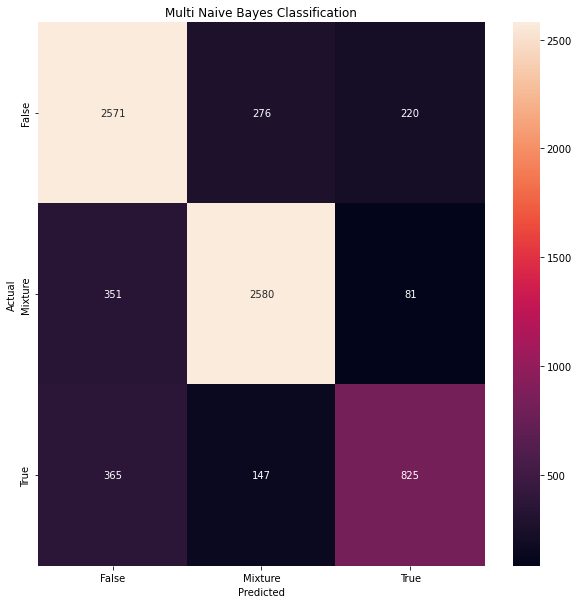

In [219]:
#Prediction visualization

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.target_names.values, yticklabels=category_id_df.target_names.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Multi Naive Bayes Classification")
plt.show()

## Support Vector Machine Classifier (SVC) 

### Linear Kernel SVC

In [207]:
# Support Vector Machine Linear Classification

svc_classifier = SVC(kernel='linear', decision_function_shape='ovo')
svc_classifier.fit(X_train, y_train)


SVC(decision_function_shape='ovo', kernel='linear')

In [208]:
#Make predictions
y_pred = svc_classifier.predict(X_test)

In [209]:
#Evaluating the model

print("Linear SVM Evaluation result for \n 1: False, 2: Mixture, 3:True")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Linear SVM Evaluation result for 
 1: False, 2: Mixture, 3:True
[[2900  148   19]
 [ 106 2885   21]
 [ 364   88  885]]
              precision    recall  f1-score   support

           1       0.86      0.95      0.90      3067
           2       0.92      0.96      0.94      3012
           3       0.96      0.66      0.78      1337

    accuracy                           0.90      7416
   macro avg       0.91      0.86      0.87      7416
weighted avg       0.90      0.90      0.90      7416



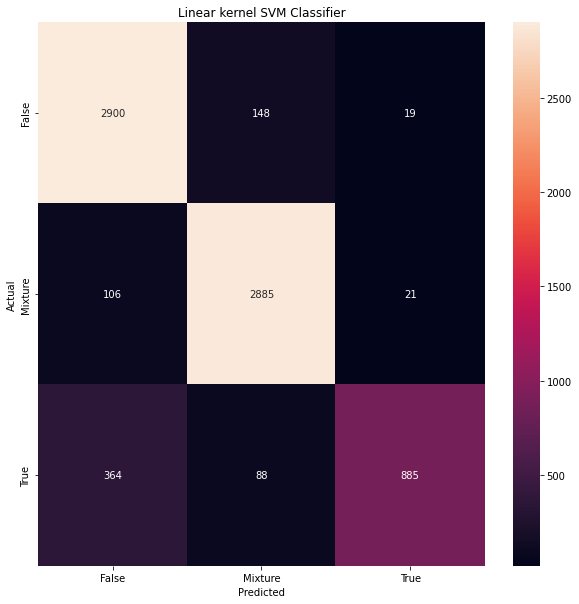

In [210]:
#Prediction visualization

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.target_names.values, yticklabels=category_id_df.target_names.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Linear kernel SVM Classifier")
plt.show()

### Polynomial Kernel SVC

In [234]:
# Support Vector Machine Non-Linear (Polynomial) Classification
svclassifier = SVC(kernel='poly', degree=8, decision_function_shape='ovo')
svclassifier.fit(X_train, y_train)

SVC(decision_function_shape='ovo', degree=8, kernel='poly')

In [235]:
#Prediction and Evaluation
y_pred = svclassifier.predict(X_test)

print("Polynomial SVM Evaluation result for \n 1: False, 2: Mixture, 3:True")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Polynomial SVM Evaluation result for 
 1: False, 2: Mixture, 3:True
[[2907   60  100]
 [1705 1270   37]
 [1090   57  190]]
              precision    recall  f1-score   support

           1       0.51      0.95      0.66      3067
           2       0.92      0.42      0.58      3012
           3       0.58      0.14      0.23      1337

    accuracy                           0.59      7416
   macro avg       0.67      0.50      0.49      7416
weighted avg       0.69      0.59      0.55      7416



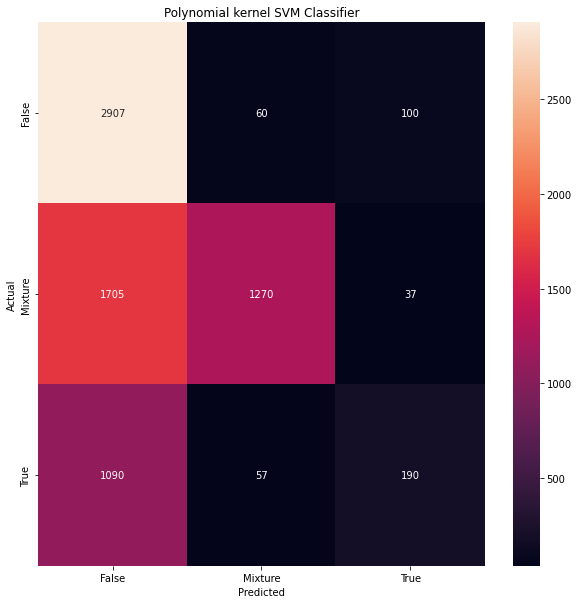

In [236]:
#Prediction visualization

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.target_names.values, yticklabels=category_id_df.target_names.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Polynomial kernel SVM Classifier")
plt.show()

### Gaussian Kernel SVC

In [237]:
#Gaussian Kernel
svclassifier = SVC(kernel='rbf', decision_function_shape='ovo')
svclassifier.fit(X_train, y_train)

SVC(decision_function_shape='ovo')

In [238]:
#Prediction and Evaluation
y_pred = svclassifier.predict(X_test)

print("Gaussian SVM Evaluation result for \n 1: False, 2: Mixture, 3:True")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Gaussian SVM Evaluation result for 
 1: False, 2: Mixture, 3:True
[[2939  105   23]
 [ 199 2797   16]
 [ 520  106  711]]
              precision    recall  f1-score   support

           1       0.80      0.96      0.87      3067
           2       0.93      0.93      0.93      3012
           3       0.95      0.53      0.68      1337

    accuracy                           0.87      7416
   macro avg       0.89      0.81      0.83      7416
weighted avg       0.88      0.87      0.86      7416



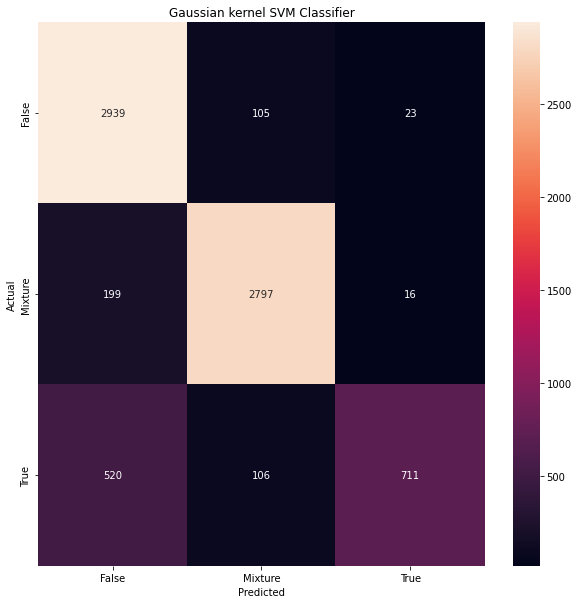

In [239]:
#Prediction visualization

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.target_names.values, yticklabels=category_id_df.target_names.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Gaussian kernel SVM Classifier")
plt.show()

## K-Nearest Neighbors Classification

In [240]:
# K-Nearest Neighbors Classification
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [241]:
#Prediction and Evaluation
y_pred = knn_classifier.predict(X_test)
print("K-Nearest Neighbors Evaluation result for \n 1: False, 2: Mixture, 3:True")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

K-Nearest Neighbors Evaluation result for 
 1: False, 2: Mixture, 3:True
[[2480  299  288]
 [ 428 2494   90]
 [ 636  168  533]]
              precision    recall  f1-score   support

           1       0.70      0.81      0.75      3067
           2       0.84      0.83      0.84      3012
           3       0.59      0.40      0.47      1337

    accuracy                           0.74      7416
   macro avg       0.71      0.68      0.69      7416
weighted avg       0.74      0.74      0.73      7416



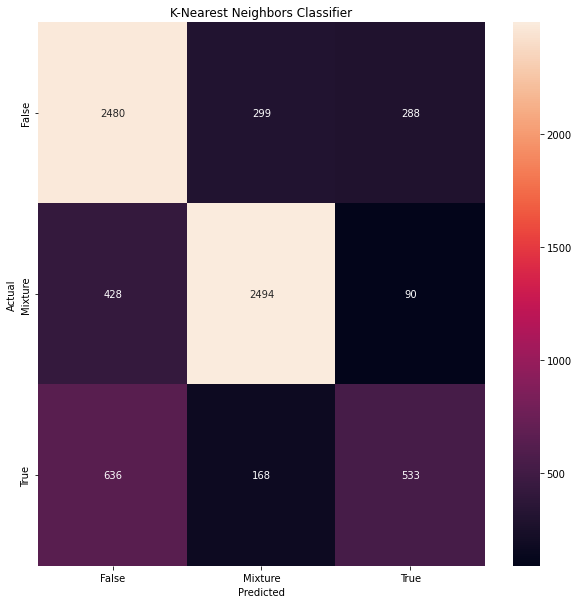

In [242]:
#Prediction visualization

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.target_names.values, yticklabels=category_id_df.target_names.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("K-Nearest Neighbors Classifier")
plt.show()

# Binary Class Classification

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [10]:
#Reading the source data file
source_df = pd.read_csv("source_features.csv")

#Integrating True and False as one unique class-Changing True labels-with equal number 3- to 1
source_df[(source_df['target_labels']==3) | (source_df['target_labels']==1)]['target_name'] = source_df.assign(target_names='Mixed_True_False')
source_df[(source_df['target_labels']==3)]['target_labels'] = source_df.assign(target_labels=1)
source_df

ValueError: ignored

In [ ]:
#Create train and test dataset
X_train = source_df.iloc[:,:-2][:17000]
y_train = source_df.target_labels[:17000]
X_test = source_df.iloc[:,:-2][17000:]
y_test = source_df.target_labels[17000:]

In [ ]:
# K-Nearest Neighbors Classification
knn_classifier = KNeighborsClassifier(n_neighbors=2)
knn_classifier.fit(X_train, y_train)

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

In [ ]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Analysis

Transactions and offers receive/view/complete plots


array([[<AxesSubplot:title={'center':'time'}>,
        <AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'reward'}>],
       [<AxesSubplot:title={'center':'offer_completed'}>,
        <AxesSubplot:title={'center':'offer_received'}>,
        <AxesSubplot:title={'center':'offer_viewed'}>],
       [<AxesSubplot:title={'center':'transaction'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

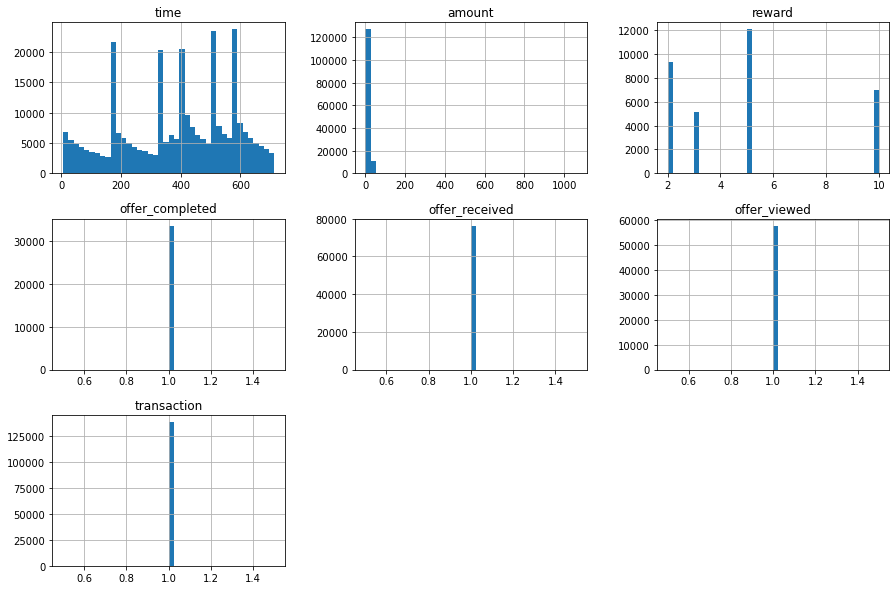

In [ ]:
print("Transactions and offers receive/view/complete plots")
transcript = pd.read_csv("transcript_edited.csv")
transcript[transcript[transcript.columns]!=0].hist(bins=40, figsize=(15, 10))

You can see number of offers that people received, viewed or completed:


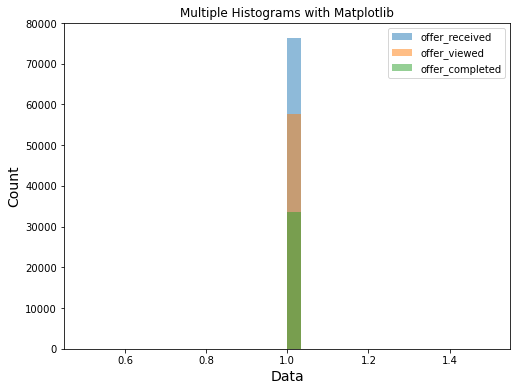

In [ ]:
print("You can see number of offers that people received, viewed or completed:")
plt.figure(figsize=(8,6))
plt.hist(transcript.offer_received[transcript.offer_received!=0], bins=30, alpha=0.5, label="offer_received")
plt.hist(transcript.offer_viewed[transcript.offer_viewed!=0], bins=30, alpha=0.5, label="offer_viewed")
plt.hist(transcript.offer_completed[transcript.offer_completed!=0], bins=30, alpha=0.5, label="offer_completed")
plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Multiple Histograms with Matplotlib")
plt.legend(loc='upper right')

Edited profile table's feature histograms:


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'income'}>],
       [<AxesSubplot:title={'center':'membership_duration'}>,
        <AxesSubplot:title={'center':'Male'}>],
       [<AxesSubplot:title={'center':'Female'}>,
        <AxesSubplot:title={'center':'Other'}>]], dtype=object)

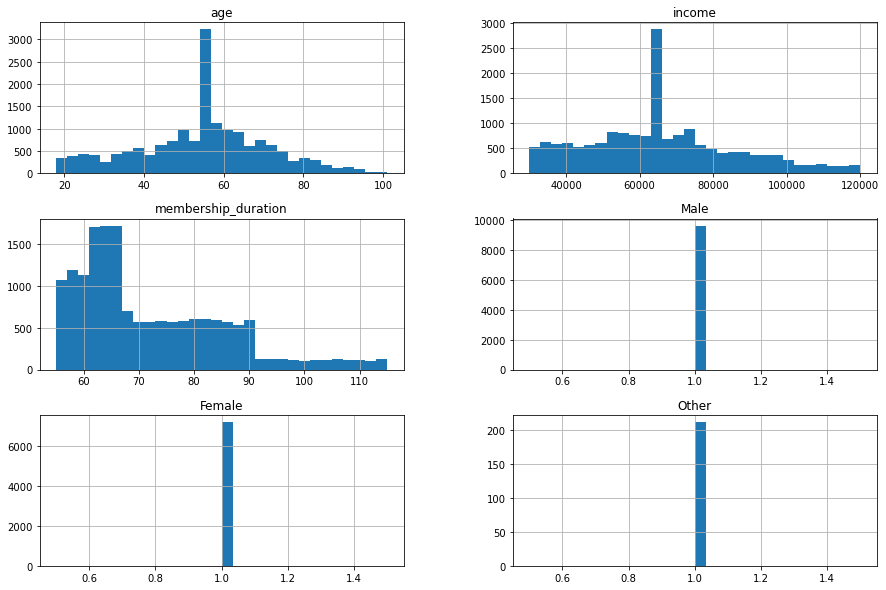

In [ ]:
print("Edited profile table's feature histograms:")
profile = pd.read_csv("profile_edited.csv")
profile[profile[profile.columns]!=0].hist(bins=30, figsize=(15, 10))

Histogram of all features


array([[<AxesSubplot:title={'center':'time'}>,
        <AxesSubplot:title={'center':'cumulative_transaction'}>,
        <AxesSubplot:title={'center':'reward'}>,
        <AxesSubplot:title={'center':'offer_completed'}>,
        <AxesSubplot:title={'center':'offer_received'}>],
       [<AxesSubplot:title={'center':'offer_viewed'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'membership_duration'}>,
        <AxesSubplot:title={'center':'Male'}>],
       [<AxesSubplot:title={'center':'Female'}>,
        <AxesSubplot:title={'center':'Other'}>,
        <AxesSubplot:title={'center':'offer_reward'}>,
        <AxesSubplot:title={'center':'offer_difficulty'}>,
        <AxesSubplot:title={'center':'offer_duration'}>],
       [<AxesSubplot:title={'center':'web'}>,
        <AxesSubplot:title={'center':'email'}>,
        <AxesSubplot:title={'center':'mobile'}>,
        <AxesSubplot:title={'center':'social'}>,
  

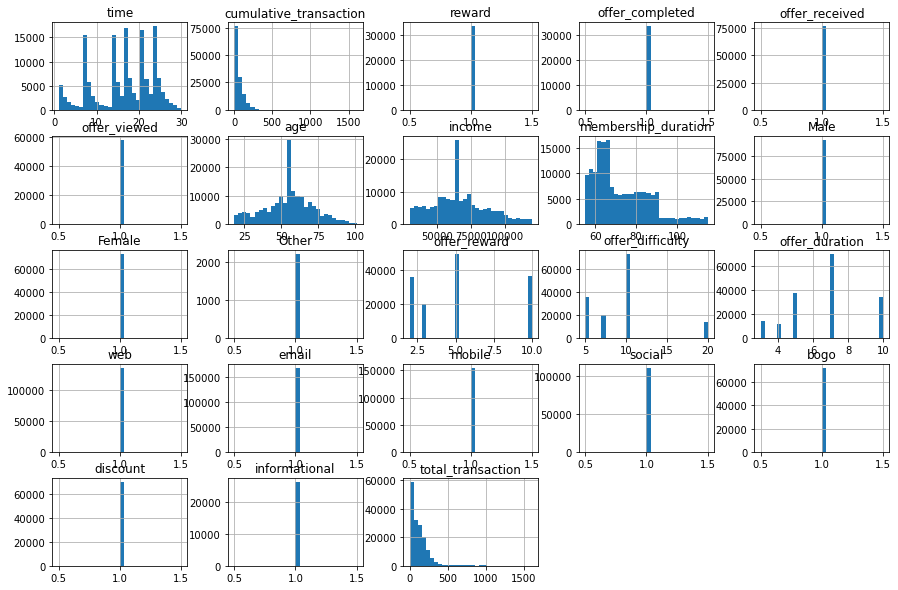

In [ ]:
#plot my source table (my_starbuck) feature histograms
my_starbuck = pd.read_csv("my_starbuck.csv")
print("Histogram of all features")
my_starbuck[my_starbuck[my_starbuck.columns]!=0].hist(bins=30, figsize=(15, 10))

Histogram of female customer's completed rewards 


<AxesSubplot:>

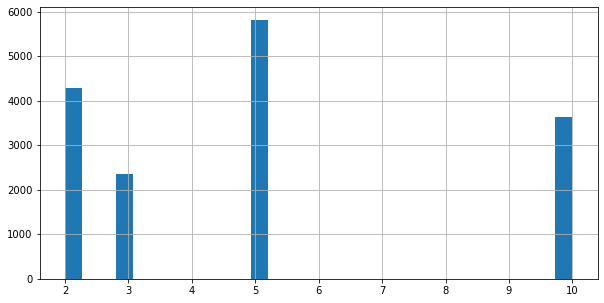

In [ ]:
print("Histogram of female customer's completed rewards ")
(my_starbuck[(my_starbuck['Female']==1) & (my_starbuck['reward']==1)]['offer_reward']).hist(bins=30, figsize=(10, 5))

Histogram of female customer's completed offer types 


array([[<AxesSubplot:title={'center':'bogo'}>,
        <AxesSubplot:title={'center':'discount'}>],
       [<AxesSubplot:title={'center':'informational'}>, <AxesSubplot:>]],
      dtype=object)

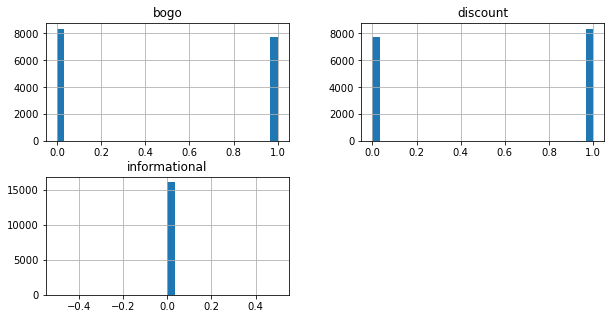

In [ ]:
print("Histogram of female customer's completed offer types ")
(my_starbuck[(my_starbuck['Female']==1) & (my_starbuck['reward']==1) ][['bogo',	'discount',	'informational']]).hist(bins=30, figsize=(10, 5))

# Training with Scikit_Learn random forest model 

In [ ]:
my_starbuck = pd.read_csv("my_starbuck.csv")
len(my_starbuck)

167581

In [ ]:
print("Number of rows containing Other genders:")
my_starbuck[(my_starbuck['Other']==1)]['person'].count()

Number of rows containing Other genders:


2190

In [ ]:
#Reading my source table
my_starbuck = pd.read_csv("my_starbuck.csv")

#Deleting the rows containing Other genders
my_starbuck = my_starbuck.drop(my_starbuck[(my_starbuck['Other']==1)].index)

#Reseting my goal table indexes
my_starbuck.reset_index(drop=True, inplace=True)

#drop unimportant and unnecessary columns
my_starbuck = my_starbuck.drop([ 'person','offers', 'Other',  'email',
                                'informational', 'offer_completed', 'offer_received', 
                                'offer_viewed', 'total_transaction',], axis=1)
#Check my source table "my_starbuck"
my_starbuck.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165391 entries, 0 to 165390
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   time                    165391 non-null  float64
 1   cumulative_transaction  165391 non-null  float64
 2   reward                  165391 non-null  int64  
 3   age                     165391 non-null  int64  
 4   income                  165391 non-null  float64
 5   membership_duration     165391 non-null  int64  
 6   Male                    165391 non-null  int64  
 7   Female                  165391 non-null  int64  
 8   offer_reward            165391 non-null  float64
 9   offer_difficulty        165391 non-null  float64
 10  offer_duration          165391 non-null  float64
 11  web                     165391 non-null  float64
 12  mobile                  165391 non-null  float64
 13  social                  165391 non-null  float64
 14  bogo                

In [ ]:
#Do some preprocessing if necessary
from sklearn import preprocessing

#Normalizing some columns that contain big numbers
x = my_starbuck[['income', 'age', 'time','membership_duration',]].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_columns = pd.DataFrame(x_scaled)

data = my_starbuck.copy()
data['income'] = normalized_columns[0]
data['age'] = normalized_columns[1]
data['time'] = normalized_columns[2]
data['membership_duration'] = normalized_columns[3]
data = data.round(5)

In [ ]:
from sklearn.model_selection import train_test_split

#splitting the data to train and test
train, test = train_test_split(
    data, test_size=0.25, random_state=42)

In [ ]:
#Saving the train and test files to csv
train.to_csv("train.csv")
test.to_csv("test.csv")

# Save data to S3, SageMaker will take training data from s3
trainpath = sess.upload_data(
    path="train.csv", bucket=bucket, key_prefix="capstone"
)

testpath = sess.upload_data(
    path="test.csv", bucket=bucket, key_prefix="capstone"
)
#print(train.shape, test.shape)

## Write model training job on a RandomForestRegressor to script.py file

In [ ]:
%%writefile script.py

import argparse
import joblib
import os

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor


# inference functions ---------------
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf


if __name__ == "__main__":

    print("extracting arguments")
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    # to simplify the demo we don't use all sklearn RandomForest hyperparameters
    parser.add_argument("--n-estimators", type=int, default=10)
    parser.add_argument("--min-samples-leaf", type=int, default=3)

    # Data, model, and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file", type=str, default="train.csv")
    parser.add_argument("--test-file", type=str, default="test.csv")
    parser.add_argument(
        "--features", type=str
    )  # in this script we ask user to explicitly name features
    parser.add_argument(
        "--target", type=str
    )  # in this script we ask user to explicitly name the target

    args, _ = parser.parse_known_args()

    print("reading data")
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))

    print("building training and testing datasets")
    X_train = train_df[args.features.split()]
    X_test = test_df[args.features.split()]
    y_train = train_df[args.target]
    y_test = test_df[args.target]

    # train
    print("training model")
    model = RandomForestRegressor(
        n_estimators=args.n_estimators, min_samples_leaf=args.min_samples_leaf, n_jobs=-1
    )

    model.fit(X_train, y_train)

    # print abs error
    print("validating model")
    abs_err = np.abs(model.predict(X_test) - y_test)

    # print couple perf metrics
    for q in [10, 50, 90]:
        print("AE-at-" + str(q) + "th-percentile: " + str(np.percentile(a=abs_err, q=q)))

    # persist model
    path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model, path)
    print("model persisted at " + path)
    print(args.min_samples_leaf)



Overwriting script.py


In [ ]:
print("train features: ", train.columns)
feature_names = ['time', 'reward', 'age', 'income',
       'membership_duration', 'Male', 'Female', 'offer_reward',
       'offer_difficulty', 'offer_duration', 'web', 'mobile', 'social', 'bogo',
       'discount' ]

train features:  Index(['time', 'cumulative_transaction', 'reward', 'age', 'income',
       'membership_duration', 'Male', 'Female', 'offer_reward',
       'offer_difficulty', 'offer_duration', 'web', 'mobile', 'social', 'bogo',
       'discount'],
      dtype='object')


## Local training

In [ ]:
! python script.py --n-estimators 100 \
                   --min-samples-leaf 2 \
                   --model-dir ./ \
                   --train ./ \
                   --test ./ \
                   --features 'time reward age income membership_duration Male Female offer_reward offer_difficulty offer_duration web mobile social bogo discount' \
                   --target cumulative_transaction

extracting arguments
reading data
building training and testing datasets
training model
validating model
AE-at-10th-percentile: 0.16653535714286247
AE-at-50th-percentile: 14.753534285714306
AE-at-90th-percentile: 66.80788100288605
model persisted at ./model.joblib
2


## Launch a Tuning Job

In [ ]:
# We use the Estimator from the SageMaker Python SDK
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"
hyperparameters = {"n-estimators": 147, \
                   "min-samples-leaf":  2, \
                  "features": 'time reward age income membership_duration Male Female offer_reward offer_difficulty offer_duration web mobile social bogo discount' , \
                   "target": 'cumulative_transaction', }

sklearn_estimator = SKLearn(
    entry_point="script.py",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m4.xlarge",#"ml.c5.xlarge",#"ml.m4.xlarge",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="train-star",
    metric_definitions=[{"Name": "median-AE", "Regex": "AE-at-50th-percentile: ([0-9.]+).*$"}],
    hyperparameters=hyperparameters,
)


In [ ]:
# we use the Hyperparameter Tuner
from sagemaker.tuner import IntegerParameter

# Define exploration boundaries
hyperparameter_ranges = {
    "n-estimators": IntegerParameter(20, 200),
    "min-samples-leaf": IntegerParameter(2, 10),
}

# create Optimizer
Optimizer = sagemaker.tuner.HyperparameterTuner(
    estimator=sklearn_estimator,
    hyperparameter_ranges=hyperparameter_ranges,
    base_tuning_job_name="tuner-star",
    objective_type="Minimize",
    objective_metric_name="median-AE",
    metric_definitions=[
        {"Name": "median-AE", "Regex": "AE-at-50th-percentile: ([0-9.]+).*$"}
    ],  # extract tracked metric from logs with regexp
    max_jobs=10,
    max_parallel_jobs=2,
)

In [ ]:
import time
tic = time.clock()

Optimizer.fit({"train": trainpath, "test": testpath})

toc = time.clock()
print(toc - tic)

..............................................................................................................................!
0.6400000000000006


In [ ]:
# get tuner results in a df
results = Optimizer.analytics().dataframe()
while results.empty:
    time.sleep(1)
    results = Optimizer.analytics().dataframe()
results.head()


,min-samples-leaf,n-estimators,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,2.0,149.0,tuner-star-220212-1631-010-14b18466,Completed,14.619602,2022-02-12 16:57:49+00:00,2022-02-12 17:00:33+00:00,164.0
1,2.0,144.0,tuner-star-220212-1631-009-5f6264cf,Completed,14.598150,2022-02-12 16:56:01+00:00,2022-02-12 16:59:24+00:00,203.0
2,2.0,147.0,tuner-star-220212-1631-008-f423754e,Completed,14.565795,2022-02-12 16:51:41+00:00,2022-02-12 16:54:23+00:00,162.0
3,2.0,190.0,tuner-star-220212-1631-007-b1bdb91a,Completed,14.626628,2022-02-12 16:49:57+00:00,2022-02-12 16:52:59+00:00,182.0
4,2.0,174.0,tuner-star-220212-1631-006-16544424,Completed,14.662675,2022-02-12 16:45:37+00:00,2022-02-12 16:48:24+00:00,167.0


In [ ]:
best_estimator=Optimizer.best_estimator()


2022-02-12 16:54:23 Starting - Preparing the instances for training
2022-02-12 16:54:23 Downloading - Downloading input data
2022-02-12 16:54:23 Training - Training image download completed. Training in progress.
2022-02-12 16:54:23 Uploading - Uploading generated training model
2022-02-12 16:54:23 Completed - Training job completed


In [ ]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"median-AE"',
 'features': '"time reward age income membership_duration Male Female offer_reward offer_difficulty offer_duration web mobile social bogo discount"',
 'min-samples-leaf': '2',
 'n-estimators': '147',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"SKLearn"',
 'sagemaker_estimator_module': '"sagemaker.sklearn.estimator"',
 'sagemaker_job_name': '"train-star-2022-02-12-16-31-17-481"',
 'sagemaker_program': '"script.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-201557610166/train-star-2022-02-12-16-31-17-481/source/sourcedir.tar.gz"',
 'target': '"cumulative_transaction"'}

In [ ]:
hyperparameters = {"n-estimators": int(best_estimator.hyperparameters()['n-estimators'].replace('"', '')), \
                   "min-samples-leaf":  int(best_estimator.hyperparameters()['min-samples-leaf'].replace('"', '')), \
                  "features": best_estimator.hyperparameters()['features'].replace('"', ''), \
                   "target": best_estimator.hyperparameters()['target'].replace('"', ''), }
hyperparameters

{'n-estimators': 147,
 'min-samples-leaf': 2,
 'features': 'time reward age income membership_duration Male Female offer_reward offer_difficulty offer_duration web mobile social bogo discount',
 'target': 'cumulative_transaction'}

## Launching a training job on best hyperparameters

In [ ]:
# We use the Estimator from the SageMaker Python SDK
from sagemaker.sklearn.estimator import SKLearn
import time

FRAMEWORK_VERSION = "0.23-1"

sklearn_estimator = SKLearn(
    entry_point="script.py",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m4.xlarge",#"ml.c5.xlarge",#"ml.m4.xlarge",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="train-star",
    metric_definitions=[{"Name": "median-AE", "Regex": "AE-at-50th-percentile: ([0-9.]+).*$"}],
    hyperparameters=hyperparameters,
)

tic = time.clock()

# launch training job
sklearn_estimator.fit({"train": trainpath, "test": testpath}, wait=True)

toc = time.clock()
print(toc - tic)

2022-02-13 02:43:41 Starting - Starting the training job...
2022-02-13 02:44:05 Starting - Launching requested ML instancesProfilerReport-1644720221: InProgress
......
2022-02-13 02:45:11 Starting - Preparing the instances for training............
2022-02-13 02:47:06 Downloading - Downloading input data
2022-02-13 02:47:06 Training - Downloading the training image.....2022-02-13 02:47:47,454 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-02-13 02:47:47,456 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-02-13 02:47:47,469 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-02-13 02:47:47,864 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-02-13 02:47:47,878 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-02-13 02:47:47,893 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus i

## Deploy to a real-time endpoint

In [ ]:
from sagemaker.sklearn.model import SKLearnModel

sklearn_estimator.latest_training_job.wait(logs="None")
artifact = sm_boto3.describe_training_job(
    TrainingJobName= sklearn_estimator.latest_training_job.name#'train-star-2022-02-11-09-09-36-428' 
)["ModelArtifacts"]["S3ModelArtifacts"]

print("Model artifact persisted at " + artifact)

model = SKLearnModel(
    model_data=artifact,
    role=get_execution_role(),
    entry_point="script.py",
    framework_version=FRAMEWORK_VERSION,
)

predictor = model.deploy(instance_type="ml.c5.large", initial_instance_count=1)


2022-02-13 02:49:26 Starting - Preparing the instances for training
2022-02-13 02:49:26 Downloading - Downloading input data
2022-02-13 02:49:26 Training - Training image download completed. Training in progress.
2022-02-13 02:49:26 Uploading - Uploading generated training model
2022-02-13 02:49:26 Completed - Training job completed
Model artifact persisted at s3://sagemaker-us-east-1-201557610166/train-star-2022-02-13-02-43-41-075/output/model.tar.gz
-----!

## Invoke the endpoint

In [ ]:
# the SKLearnPredictor does the serialization from pandas for us
response = predictor.predict(test[feature_names])
test_target = test['cumulative_transaction']
test_target = test_target.to_numpy() 

print("response \t\t target")
for i in range(100):
    print(response[i] , "\t",test_target[i])

response 		 target
42.741547781017154 	 42.75
62.41656648850017 	 31.57
5.431426303854877 	 0.0
111.42925178166503 	 61.63
119.83790046971173 	 146.2
30.473342484612882 	 37.57
81.09920667314543 	 29.75
73.52277721088433 	 73.36
5.504794001727676 	 2.54
35.42429664723034 	 20.41
132.62019595616022 	 138.12
45.86012331281719 	 23.98
57.533254994061096 	 33.6
61.2219977324263 	 37.06
56.77866553287983 	 20.52
14.928407446672761 	 128.26
20.11640678652412 	 29.56
39.824623744735995 	 121.08
64.26413265306118 	 33.97
6.332217624867687 	 8.84
20.02664085951841 	 12.79
15.32111321671525 	 0.0
138.58601587301595 	 789.81
110.23857701652086 	 55.65
144.37812649821834 	 155.09
107.90099708454815 	 124.15
69.68707636864272 	 83.38
124.63938921282798 	 130.97
0.0 	 0.0
8.765819327214734 	 3.92
1.18198223733938 	 0.05
81.47381827016518 	 99.23
89.95767454918476 	 108.05
48.186443013713415 	 109.19
0.0 	 0.0
89.26236799481691 	 76.01
10.935080793356306 	 0.0
50.988030936184 	 19.95
95.8436182917611

## Evaluate the sklearn random forest model

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mean_squared_error = mean_squared_error(test_target, response)
mean_absolute_error = mean_absolute_error(test_target, response)
r2_score = r2_score(test_target, response)
print(f"R2 score: {r2_score}, mean_squared_error: {mean_squared_error}, mean_absolute_error {mean_absolute_error}")

R2 score: 0.4523693254058069, mean_squared_error: 4236.3759983377595, mean_absolute_error 29.62099167956011


## Delete the endpoint

In [ ]:
#Don’t forget to delete the endpoint!
predictor.delete_endpoint()

# Training with autogluon.tabular

Because the R2 score of the Scikit_Learn Random Forest model is rather low, we train the dataset using Autogluon Tabular models to check if we obtain better results. We know that autogluon.tabular contains RFModel (Random Forest model (scikit-learn)) as one of its models. So we hope we will certainly improve the result.

In [ ]:
from sklearn.model_selection import train_test_split

#Read from my source table
my_starbuck = pd.read_csv("my_starbuck.csv")

#Splitting to train and test files
train, test = train_test_split(
    my_starbuck, test_size=0.25, random_state=42
)
print(train.shape, test.shape)

(125685, 25) (41896, 25)


In [ ]:
for col in ['text', 'author', 'headline', 'named_entities_claim', 'named_entities_article', 'keywords', ]:
  claimskg[col] = claimskg[col].astype('string')
claimskg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24452 entries, 0 to 24451
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      24452 non-null  object
 1   text                    24452 non-null  string
 2   date                    24452 non-null  object
 3   truthRating             24452 non-null  int64 
 4   ratingName              24452 non-null  object
 5   author                  24452 non-null  string
 6   headline                24452 non-null  string
 7   named_entities_claim    24421 non-null  string
 8   named_entities_article  15340 non-null  string
 9   keywords                23162 non-null  string
 10  link                    24452 non-null  object
 11  language                24452 non-null  object
 12  politifact              24452 non-null  int64 
 13  snopes                  24452 non-null  int64 
 14  africacheck             24452 non-null  int64 
 15  tr

In [ ]:

#Splitting to train and test files
train, test = train_test_split(
    claimskg, test_size=0.25, random_state=42
)
print(train.shape, test.shape)

(18339, 18) (6113, 18)


In [ ]:

from autogluon.tabular import TabularPredictor

#Training with Autogluon Tabular
save_path = 'kg_models'
predictor = TabularPredictor('truthRating', problem_type= 'quantile', 
                                          path=save_path, learner_kwargs={'ignored_columns':['ratingName', 'id','language', 'link','date']} ).fit(train, time_limit=600, presets='best_quality')

Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "kg_models/"
AutoGluon Version:  0.3.1
Train Data Rows:    18339
Train Data Columns: 17
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Dropping user-specified ignored columns: ['ratingName', 'id', 'language', 'link']
Fitting AutoMLPipelineFeatureGenerator...
Cannot interpret 'string[python]' as a data type
Cannot interpret 'string[python]' as a data type
Cannot interpret 'string[python]' as a data type
Cannot interpret 'string[python]' as a data type
Cannot interpret 'string[python]' as a data type
Cannot interpret 'string[python]' as a data type
	Available Memory:                    10994.55 MB
	Train Data (Original)  Memory Usage: 20.04 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
Cannot interpre

## My Tabular predictor leaderboard

In [ ]:
#The predictor leaderboard that is produced using the data previously reserved for validation inside fit, and can display extra information about each model:
predictor.leaderboard(extra_info=True, silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order,num_features,num_models,num_models_w_ancestors,memory_size,memory_size_w_ancestors,memory_size_min,memory_size_min_w_ancestors,num_ancestors,num_descendants,model_type,child_model_type,hyperparameters,hyperparameters_fit,ag_args_fit,features,child_hyperparameters,child_hyperparameters_fit,child_ag_args_fit,ancestors,descendants
0,LightGBMXT_BAG_L2,0.642401,66.866308,407.575410,1.163145,92.054415,2,True,6,1691,10,32,6483868,453031714,1545300,228045277,4,1,StackerEnsembleModel,LGBModel,"{'use_orig_features': True, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': True}",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'drop_unique': False}","[__nlp__.jeb bush, __nlp__.largest, __nlp__.prevention, __nlp__.check, __nlp__.trafficking, headline.symbol_ratio.., __nlp__.york university, __nlp__.republican republican, __nlp__.illinois, __nlp__.live, __nlp__.white house, __nlp__.super, __nlp__.oil, __nlp__.last, __nlp__.biden, __nlp__.the speech, __nlp__.red, __nlp__.agreement, __nlp__.attack, __nlp__.william, __nlp__.joint, __nlp__.term, __nlp__.clinton, __nlp__.asp, __nlp__.office, __nlp__.past, __nlp__.workers, __nlp__.study, headline.symbol_ratio.!, __nlp__.human, __nlp__.washington post, RandomForestEntr_BAG_L1_1, __nlp__.africa,...","{'num_boost_round': 10000, 'num_threads': -1, 'learning_rate': 0.05, 'objective': 'multiclass', 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True, 'extra_trees': True}",{'num_boost_round': 41},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'ignored_type_group_special': None, 'ignored_type_group_raw': ['object'], 'get_features_kwargs': None, 'get_features_kwargs_extra': None}","[RandomForestGini_BAG_L1, LightGBMXT_BAG_L1, LightGBM_BAG_L1, RandomForestEntr_BAG_L1]",[WeightedEnsemble_L3]
1,WeightedEnsemble_L3,0.642401,66.868493,408.667719,0.002186,1.092308,3,True,8,3,1,33,3159,453034873,3159,228045277,5,0,WeightedEnsembleModel,GreedyWeightedEnsembleModel,"{'use_orig_features': False, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': True}",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'drop_unique': False}","[LightGBMXT_BAG_L2_2, LightGBMXT_BAG_L2_1, LightGBMXT_BAG_L2_0]",{'ensemble_size': 100},{'ensemble_size': 1},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'drop_unique': False}","[LightGBMXT_BAG_L2, RandomForestGini_BAG_L1, LightGBMXT_BAG_L1, RandomForestEntr_BAG_L1, LightGBM_BAG_L1]",[]
2,LightGBMXT_BAG_L1,0.642183,2.298393,111.418195,2.298393,111.418195,1,True,1,1679,10,10,21781231,21781231,4337878,4337878,0,4,StackerEnsembleModel,LGBModel,"{'use_orig_features': True, 'max_base_models': 25, 'max_base_models_per_type': 5, 'save_bag_folds': True}",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limit_ratio': 1.0, 'max_time_limit': None, 'min_time_limit': 0, 'ignored_type_group_special': None, 'ignored_type_group_raw': None, 'get_features_kwargs': None, 'get_features_kwargs_extra': None, 'drop_unique': False}","[__nlp__.jeb bush, __nlp__.largest, __nlp__.prevention, __nlp__.check, __nlp__.trafficking, headline.symbol_ratio.., __nlp__.york university, __nlp__.republican republican, __nlp__.illinois, __nlp__.live, __nlp__.white house, __nlp__.super, __nlp__.oil, __nlp__.last, __nlp__.biden, __nlp__.the speech, __n

In [ ]:
print("Predictor features: ", predictor.features())

Predictor features:  ['text', 'date', 'author', 'headline', 'named_entities_claim', 'named_entities_article', 'keywords', 'politifact', 'snopes', 'africacheck', 'truthorfiction', 'factscan', 'checkyourfact']


## Getting predictions from TabularPredictor

In [ ]:
response = predictor.predict(test)
test_target = test['truthRating']

In [ ]:
print("response:\n ",response)
print("target:\n",test_target)

response:
  11830    1
16166    2
14929    2
16533    2
13570    2
        ..
18744    2
24436    2
1991     2
2536     1
15400    2
Name: truthRating, Length: 6113, dtype: int64
target:
 11830    1
16166    2
14929    2
16533    2
13570    1
        ..
18744    2
24436    2
1991     3
2536     3
15400    2
Name: truthRating, Length: 6113, dtype: int64


## Evaluate the Autogluon predictor

In [ ]:
predictor.evaluate(test)

Evaluation: accuracy on test data: 0.6466546703746114
Evaluations on test data:
{
    "accuracy": 0.6466546703746114,
    "balanced_accuracy": 0.5483951943900663,
    "mcc": 0.430211010537751
}


{'accuracy': 0.6466546703746114,
 'balanced_accuracy': 0.5483951943900663,
 'mcc': 0.430211010537751}

## Feature importance

In [ ]:
feature_importance = predictor.feature_importance(test)
feature_importance

Computing feature importance via permutation shuffling for 13 features using 1000 rows with 3 shuffle sets...
	217.08s	= Expected runtime (72.36s per shuffle set)
	177.64s	= Actual runtime (Completed 3 of 3 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
named_entities_claim,0.054000,0.007810,0.003450,3,0.098754,0.009246
headline,0.019667,0.001528,0.001002,3,0.028420,0.010914
keywords,0.019000,0.006083,0.016254,3,0.053855,-0.015855
author,0.014667,0.005132,0.019233,3,0.044071,-0.014738
politifact,0.014667,0.009018,0.053156,3,0.066344,-0.037010
text,0.011000,0.006557,0.050427,3,0.048575,-0.026575
africacheck,0.002333,0.002082,0.095855,3,0.014262,-0.009595
date,0.001333,0.004726,0.336701,3,0.028413,-0.025746
named_entities_article,0.000667,0.001155,0.211325,3,0.007283,-0.005950
snopes,0.000333,0.001528,0.370901,3,0.009086,-0.008420


In [ ]:
predictor.get_model_best()

'LightGBMXT_BAG_L2'

# Results:

We can observe that the WeightedEnsemble model (that implements Ensemble Selection) is trained in the stack level 3 can predict our data at the best. A model with “_L3” suffix is a not base model, meaning it depends on other models.
